# 3.2.1 Deep analysis of AVERANGE_ROW_COUNT 

This dashboard answers the following questions:
- [X] How to retrieve components from report logs
- [X] Which "Lightning component"  are fetching an amount of data of more than the averge?
- [X] Which columns are present on those Lightning component reports?

In [1]:
import os
import pandas as pd

In [2]:
os.listdir("data/Salesforce/ELF/Report/")

['2022-06-20_Report.csv', '2022-06-05_Report.csv', '2022-06-04_Report.csv']

### Loading reports

In [3]:
reports = pd.read_csv("data/Salesforce/ELF/Report/2022-06-20_Report.csv",low_memory=False)

In [4]:
reports.shape

(705, 31)

In [5]:
list(reports.columns)

['EVENT_TYPE',
 'TIMESTAMP',
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'RUN_TIME',
 'CPU_TIME',
 'URI',
 'SESSION_KEY',
 'LOGIN_KEY',
 'USER_TYPE',
 'REQUEST_STATUS',
 'DB_TOTAL_TIME',
 'ENTITY_NAME',
 'DISPLAY_TYPE',
 'RENDERING_TYPE',
 'REPORT_ID',
 'ROW_COUNT',
 'NUMBER_EXCEPTION_FILTERS',
 'NUMBER_COLUMNS',
 'AVERAGE_ROW_SIZE',
 'SORT',
 'DB_BLOCKS',
 'DB_CPU_TIME',
 'NUMBER_BUCKETS',
 'TIMESTAMP_DERIVED',
 'USER_ID_DERIVED',
 'CLIENT_IP',
 'URI_ID_DERIVED',
 'REPORT_ID_DERIVED',
 'ORIGIN']

Let's sorted table values by `AVERAGE_ROW_SIZE`(ARS) column to start the filters

In [6]:
sorted_by_ARS = reports.sort_values('AVERAGE_ROW_SIZE', ascending=False)
sorted_by_ARS

,EVENT_TYPE,TIMESTAMP,REQUEST_ID,ORGANIZATION_ID,USER_ID,RUN_TIME,CPU_TIME,URI,SESSION_KEY,LOGIN_KEY,...,SORT,DB_BLOCKS,DB_CPU_TIME,NUMBER_BUCKETS,TIMESTAMP_DERIVED,USER_ID_DERIVED,CLIENT_IP,URI_ID_DERIVED,REPORT_ID_DERIVED,ORIGIN
690,Report,2.022062e+13,SLB:fe7972f2c81bad5511f94d34b0cd1843,00D0b000000GaMp,0050b000004K3eB,486,396,/aura,9YkqD4AubILkP3/t,E2TuHYqfPqQzwGBR,...,0722R000004XnLB.up,2570,40,0,2022-06-20T00:58:56.647Z,0050b000004K3eBAAS,132.237.180.16,NaN,00O0b000004kTazEAE,ReportRunFromLightning
366,Report,2.022062e+13,SLB:5e79fdcfdb4971d4ed1f24387e90059c,00D0b000000GaMp,0050b000004K3eB,499,396,/aura,9YkqD4AubILkP3/t,E2TuHYqfPqQzwGBR,...,0722R000004XnLB.up,2419,30,0,2022-06-20T00:33:56.642Z,0050b000004K3eBAAS,132.237.180.16,NaN,00O0b000004kTazEAE,ReportRunFromLightning
548,Report,2.022062e+13,SLB:cbb8048397779a70b5d55fe0e9ea5cc0,00D0b000000GaMp,0050b000004KPIb,433,344,/aura,srlQ5cWzTAhCtU+x,ql+MK97K22TbFFb2,...,0722R000004XnLB.up,2726,40,0,2022-06-20T00:49:24.270Z,0050b000004KPIbAAO,163.244.22.10,NaN,00O0b000004kTazEAE,ReportRunFromLightning
335,Report,2.022062e+13,TID:79645900009bee2629,00D0b000000GaMp,0052R000009iwSB,25932,2027,/aura,afgB1BIQizlV7qCl,fFEZMvJkhgfFxG86,...,NaN,676952,9820,0,2022-06-20T00:31:37.329Z,0052R000009iwSBQAY,132.237.171.41,NaN,00O2R000004Am4AUAS,ReportRunFromLightning
43,Report,2.022062e+13,SLB:78d30154e89677a9331fa0667403c49e,00D0b000000GaMp,0050b000005CdG6,719,348,/00O6P0000016vVPUAY,/He3P3omfKuHKU5e,U6yuiD9DkMAEltdb,...,NaN,6249,50,0,2022-06-20T00:11:35.554Z,0050b000005CdG6AAK,143.166.253.244,00O6P0000016vVPUAY,00O6P0000016vVPUAY,ReportRunFromClassic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
344,Report,2.022062e+13,4jcgq7pFiKAMxtG-mNHE--,00D0b000000GaMp,0050b000004K7hO,9514,173,NaN,NaN,NaN,...,NaN,685,30,2,2022-06-20T00:32:11.134Z,0050b000004K7hOAAS,NaN,NaN,00O2R000003s1byUAA,ChartRenderedInEmbeddedAnalyticsApp
330,Report,2.022062e+13,TID:22851327900009aa10,00D0b000000GaMp,0052R000009TlFS,522,255,/aura,HaNhdytuc5gCTTm9,lS2nTqluSh74uEyr,...,NaN,889,30,0,2022-06-20T00:31:30.223Z,0052R000009TlFSQA0,163.244.182.13,NaN,00O0b000006iNwdEAE,ReportRunFromLightning
326,Report,2.022062e+13,4jcgnL0jR41wNOG-mNFnl-,00D0b000000GaMp,0052R000009Tqd7,5344,124,NaN,NaN,NaN,...,0720b000001dxwL.up,796,50,0,2022-06-20T00:31:18.966Z,0052R000009Tqd7QAC,NaN,NaN,00O0b000004kkZKEAY,ChartRenderedInEmbeddedAnalyticsApp
325,Report,2.022062e+13,TID:67362720000066a491,00D0b000000GaMp,0050b000004KDSS,452,254,/aura,tlKaJ5dVx8aL3d9H,aJyHuonh5/1/0ZiA,...,NaN,835,20,0,2022-06-20T00:31:14.328Z,0050b000004KDSSAA4,143.166.226.114,NaN,00O0b000004AmRrEAK,ReportRunFromLightning


Let's remove unsed columns

In [7]:
sorted_by_ARS = sorted_by_ARS.drop(columns=[
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'URI',
 'LOGIN_KEY',
 'USER_TYPE',
 'REQUEST_STATUS',
 'DB_TOTAL_TIME',
 'ENTITY_NAME',
 'DISPLAY_TYPE',
 'RENDERING_TYPE',
 'REPORT_ID',
 'SORT',
 'NUMBER_BUCKETS',
 'USER_ID_DERIVED',
 'CLIENT_IP',
 'URI_ID_DERIVED'])

In [8]:
list(sorted_by_ARS)

['EVENT_TYPE',
 'TIMESTAMP',
 'RUN_TIME',
 'CPU_TIME',
 'SESSION_KEY',
 'ROW_COUNT',
 'NUMBER_EXCEPTION_FILTERS',
 'NUMBER_COLUMNS',
 'AVERAGE_ROW_SIZE',
 'DB_BLOCKS',
 'DB_CPU_TIME',
 'TIMESTAMP_DERIVED',
 'REPORT_ID_DERIVED',
 'ORIGIN']

Let's try remove row's with 0 and missing values in `AVERAGE_ROW_SIZE`

In [9]:
sorted_by_ARS.drop(sorted_by_ARS[(sorted_by_ARS["AVERAGE_ROW_SIZE"] == 0)].index, inplace=True)
sorted_by_ARS.dropna(subset='AVERAGE_ROW_SIZE')
sorted_by_ARS.shape

(464, 14)

Let's try to mean the values of `AVERAGE_ROW_SIZE` column

In [10]:
mean = sorted_by_ARS["AVERAGE_ROW_SIZE"].mean()
mean

846.6163793103449

Let's define functions for filtering mean and median of values.

In [11]:
def filter_ars_by_mean(ars_value):
    return ars_value > mean 

### Until the moment
So far, we have been able to:
- [x] Clear data to apply filtering
- [x] Keep only as apparent to relationships

And let's start from:

- [ ] Apply filtering
- [ ] Make plot's for each one of them



Importing matplotlib.pyplot for making the plots

In [12]:
import matplotlib.pyplot as plt

Applying the filters for mean and median

In [13]:
above_mean = sorted_by_ARS["AVERAGE_ROW_SIZE"].apply(filter_ars_by_mean)

Generating the plot

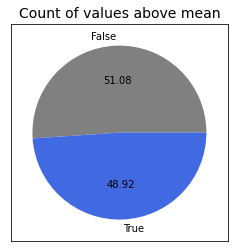

False    237
True     227
Name: AVERAGE_ROW_SIZE, dtype: int64

In [31]:
# Making a plot
labels = above_mean.unique()
plt.pie(above_mean.value_counts(), autopct="%.2f", labels=[labels[1], labels[0]], colors=["grey", "royalblue"])
plt.title('Count of values above mean', fontsize=14)
plt.box(on=None)
plt.show()
above_mean.value_counts()

### After visualizing the values ​​that are above the mean and median, we can conclude that:


-  We can  conclude that the result would be approximate when it came to checking the values ​​above the mean

>Concluding the first part of the answered question, where in the sample of reports for the date 2022-06-20, **we have approximately 49% of Lightning component type events** with change lines above the average.

## Loading ELF tables


>Now we will make the relationship with the PageView table, so we can analyze which Lightning-type pages are accessed and edited

In [15]:
os.listdir("data/Salesforce/ELF/LightningPageView")

['2022-06-04_LightningPageView.csv',
 '2022-06-05_LightningPageView.csv',
 '2022-06-20_LightningPageView.csv']

In [16]:
page_view = pd.read_csv("data/Salesforce/ELF/LightningPageView/2022-06-20_LightningPageView.csv")
page_view.shape

(9671, 50)

In [17]:
list(page_view.columns)

['EVENT_TYPE',
 'TIMESTAMP',
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'CLIENT_ID',
 'SESSION_KEY',
 'LOGIN_KEY',
 'USER_TYPE',
 'APP_NAME',
 'DEVICE_PLATFORM',
 'SDK_APP_VERSION',
 'OS_NAME',
 'OS_VERSION',
 'USER_AGENT',
 'BROWSER_NAME',
 'BROWSER_VERSION',
 'SDK_VERSION',
 'DEVICE_MODEL',
 'DEVICE_ID',
 'SDK_APP_TYPE',
 'CLIENT_GEO',
 'CONNECTION_TYPE',
 'UI_EVENT_ID',
 'UI_EVENT_SOURCE',
 'UI_EVENT_TIMESTAMP',
 'PAGE_START_TIME',
 'DURATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION_REASON',
 'EFFECTIVE_PAGE_TIME_DEVIATION_ERROR_TYPE',
 'EFFECTIVE_PAGE_TIME',
 'DEVICE_SESSION_ID',
 'UI_EVENT_SEQUENCE_NUM',
 'PAGE_ENTITY_ID',
 'PAGE_ENTITY_TYPE',
 'PAGE_CONTEXT',
 'PAGE_URL',
 'PAGE_APP_NAME',
 'PREVPAGE_ENTITY_ID',
 'PREVPAGE_ENTITY_TYPE',
 'PREVPAGE_CONTEXT',
 'PREVPAGE_URL',
 'PREVPAGE_APP_NAME',
 'TARGET_UI_ELEMENT',
 'PARENT_UI_ELEMENT',
 'GRANDPARENT_UI_ELEMENT',
 'TIMESTAMP_DERIVED',
 'USER_ID_DERIVED',
 'CLIENT_IP']

Let's find the table that is related to the reports

In [18]:
page_view.SESSION_KEY

0       DkrMLnselIW4a5EP
1       FNYwFEC/js/SJBfr
2       kli/tj2J178nuyC/
3       13BZwFCUcj0WV/FF
4       SFUtGUXsW73SFMp1
              ...       
9666    7l79yoIIpgXhppu9
9667    FFqIXSkd1lg3R12W
9668    zSlTWpkr6eIMM1jJ
9669    fpCpwvb6vZPBenEc
9670    U3NQu4Q8EcuJetZc
Name: SESSION_KEY, Length: 9671, dtype: object

Let's relate these tables in a single data frame

In [19]:
page_view_related = pd.merge(left=sorted_by_ARS, right=page_view, left_on="SESSION_KEY", right_on="SESSION_KEY")
list(page_view_related.columns)

['EVENT_TYPE_x',
 'TIMESTAMP_x',
 'RUN_TIME',
 'CPU_TIME',
 'SESSION_KEY',
 'ROW_COUNT',
 'NUMBER_EXCEPTION_FILTERS',
 'NUMBER_COLUMNS',
 'AVERAGE_ROW_SIZE',
 'DB_BLOCKS',
 'DB_CPU_TIME',
 'TIMESTAMP_DERIVED_x',
 'REPORT_ID_DERIVED',
 'ORIGIN',
 'EVENT_TYPE_y',
 'TIMESTAMP_y',
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'CLIENT_ID',
 'LOGIN_KEY',
 'USER_TYPE',
 'APP_NAME',
 'DEVICE_PLATFORM',
 'SDK_APP_VERSION',
 'OS_NAME',
 'OS_VERSION',
 'USER_AGENT',
 'BROWSER_NAME',
 'BROWSER_VERSION',
 'SDK_VERSION',
 'DEVICE_MODEL',
 'DEVICE_ID',
 'SDK_APP_TYPE',
 'CLIENT_GEO',
 'CONNECTION_TYPE',
 'UI_EVENT_ID',
 'UI_EVENT_SOURCE',
 'UI_EVENT_TIMESTAMP',
 'PAGE_START_TIME',
 'DURATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION_REASON',
 'EFFECTIVE_PAGE_TIME_DEVIATION_ERROR_TYPE',
 'EFFECTIVE_PAGE_TIME',
 'DEVICE_SESSION_ID',
 'UI_EVENT_SEQUENCE_NUM',
 'PAGE_ENTITY_ID',
 'PAGE_ENTITY_TYPE',
 'PAGE_CONTEXT',
 'PAGE_URL',
 'PAGE_APP_NAME',
 'PREVPAGE_ENTITY_ID',
 'PREVP

Let's remove unsed columns

In [20]:
page_view_related = page_view_related.drop(columns=['EVENT_TYPE_x',
 'TIMESTAMP_x',
 'NUMBER_EXCEPTION_FILTERS',
 'DB_BLOCKS',
 'TIMESTAMP_DERIVED_x',
 'REPORT_ID_DERIVED',
 'EVENT_TYPE_y',
 'TIMESTAMP_y',
 'REQUEST_ID',
 'ORGANIZATION_ID',
 'USER_ID',
 'CLIENT_ID',
 'LOGIN_KEY',
 'USER_TYPE',
 'APP_NAME',
 'DEVICE_PLATFORM',
 'SDK_APP_VERSION',
 'USER_AGENT',
 'BROWSER_NAME',
 'BROWSER_VERSION',
 'SDK_VERSION',
 'DEVICE_MODEL',
 'DEVICE_ID',
 'SDK_APP_TYPE',
 'CONNECTION_TYPE',
 'UI_EVENT_ID',
 'UI_EVENT_SOURCE',
 'UI_EVENT_TIMESTAMP',
 'PAGE_START_TIME',
 'EFFECTIVE_PAGE_TIME_DEVIATION',
 'EFFECTIVE_PAGE_TIME_DEVIATION_REASON',
 'EFFECTIVE_PAGE_TIME_DEVIATION_ERROR_TYPE',
 'EFFECTIVE_PAGE_TIME',
 'DEVICE_SESSION_ID',
 'UI_EVENT_SEQUENCE_NUM',
 'PAGE_ENTITY_ID',
 'PAGE_ENTITY_TYPE',
 'PAGE_URL',
 'PAGE_APP_NAME',
 'PREVPAGE_ENTITY_ID',
 'PREVPAGE_ENTITY_TYPE',
 'PREVPAGE_CONTEXT',
 'PREVPAGE_URL',
 'PREVPAGE_APP_NAME',
 'TARGET_UI_ELEMENT',
 'PARENT_UI_ELEMENT',
 'GRANDPARENT_UI_ELEMENT',
 'TIMESTAMP_DERIVED_y',
 'USER_ID_DERIVED',
 'CLIENT_IP'], axis=1)

Let's remove 0 and missing values at `AVERAGE_ROW_SIZE`

In [21]:
page_view_related = page_view_related.dropna(subset='AVERAGE_ROW_SIZE')
page_view_related

,RUN_TIME,CPU_TIME,SESSION_KEY,ROW_COUNT,NUMBER_COLUMNS,AVERAGE_ROW_SIZE,DB_CPU_TIME,ORIGIN,OS_NAME,OS_VERSION,CLIENT_GEO,DURATION,PAGE_CONTEXT
0,25932,2027,afgB1BIQizlV7qCl,19562,41,2130,9820,ReportRunFromLightning,WINDOWS,10.0,United States/null,6523.0,one:recordHomeFlexipage2Wrapper
1,9257,542,HCJma63FyiNrZe2B,40,44,1890,30,ReportRunFromLightning,WINDOWS,10.0,United States/null,1070.0,one:recordHomeFlexipage
2,7729,527,HCJma63FyiNrZe2B,39,44,1889,30,ReportRunFromLightning,WINDOWS,10.0,United States/null,1070.0,one:recordHomeFlexipage
3,7145,469,HCJma63FyiNrZe2B,39,44,1889,20,ReportRunFromLightning,WINDOWS,10.0,United States/null,1070.0,one:recordHomeFlexipage
4,7172,538,umX93njPuhSNbMiL,18,44,1880,30,ReportRunFromLightning,WINDOWS,10.0,United States/Texas,3211.0,one:recordHomeFlexipage2Wrapper
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1204,220,158,Mfq70kKbUQwpZFaS,5,2,122,10,ReportRunFromLightning,WINDOWS,10.0,United States/null,360.0,force:objectHomeDesktop
1205,220,158,Mfq70kKbUQwpZFaS,5,2,122,10,ReportRunFromLightning,WINDOWS,10.0,United States/null,6699.0,one:recordHomeFlexipage2Wrapper
1206,220,158,Mfq70kKbUQwpZFaS,5,2,122,10,ReportRunFromLightning,WINDOWS,10.0,United States/null,1001.0,one:recordHomeFlexipage2Wrapper
1207,220,158,Mfq70kKbUQwpZFaS,5,2,122,10,ReportRunFromLightning,WINDOWS,10.0,United States/null,376.0,one:recordHomeFlexipage2Wrapper


In [22]:
page_view_related["AVERAGE_ROW_SIZE"]

0       2130
1       1890
2       1889
3       1889
4       1880
        ... 
1204     122
1205     122
1206     122
1207     122
1208     122
Name: AVERAGE_ROW_SIZE, Length: 1209, dtype: int64

In [23]:
page_view_related["ROW_COUNT"]

0       19562
1          40
2          39
3          39
4          18
        ...  
1204        5
1205        5
1206        5
1207        5
1208        5
Name: ROW_COUNT, Length: 1209, dtype: int64

### Now let's follow these steps:

- Apply the mean filters with the related table

- Generate a visualization for each applied filter

Applying filter

In [24]:
page_view_mean = page_view_related["AVERAGE_ROW_SIZE"].apply(filter_ars_by_mean)

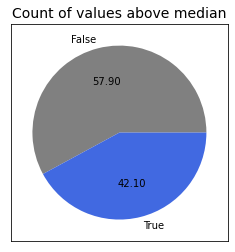

False    700
True     509
Name: AVERAGE_ROW_SIZE, dtype: int64

In [25]:
# Making a plot
labels = page_view_mean.unique()
plt.pie(page_view_mean.value_counts(), autopct="%.2f", labels=[labels[1], labels[0]], colors=["grey", "royalblue"])
plt.title('Count of values above median', fontsize=14)
plt.box(on=None)
plt.show()
page_view_mean.value_counts()

### In this visualization, we got some results a bit:

- The amount of `ReportRunFromLightning` source events have a **slightly smaller amount of interactions above the average and median compared to Reports**



- It was possible to identify other ways to explore a little more about these views, such as region, operating system, CPU time (related to the time the data is accessed), allowing new fronts for analysis of these events

>Thus, concluding these two questions raised in this notebook.

